In [88]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn import feature_extraction
import datetime
import pickle

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [4]:
df = df.drop('down_votes', axis=1)
df = df.drop('category', axis=1)
df = df.drop('over_18', axis=1)

In [6]:
title = df.title

In [9]:
def convert_date(time_cre):
    d = datetime.datetime.fromtimestamp(time_cre)
    date_time = d.isoformat()
    date, time = date_time[:10], int(date_time[11:13])//2*2
    return date, time

def convert_wkd(date):
    d = pd.Timestamp(date)
    return d.weekday()

df.date_created = df.time_created.apply(lambda x: convert_date(x)[0])
df.time_created = df.time_created.apply(lambda x: convert_date(x)[1])
df['weekday_created'] = df.date_created.apply(lambda x: convert_wkd(x))

In [10]:
df['season'] = df.date_created.apply(lambda x: (int(x[5 : 7]) - 1) // 3)
df['year'] = df.date_created.apply(lambda x: int(x[: 4]))

## trends of news and upvotes

In [12]:
news_by_season = df[['year','season','title']].groupby(['year','season']).count()

In [59]:
#Number of News vs Season
month_list = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']

season_list = ['Winter', 'Spring','Summer','Autumn']
weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_list = list(range(0,24,2))
year_list = list(range(2008,2017))
year_season = [str(i) + ' ' + j  for i in year_list for j in season_list]
weekday_time = [i + ' ' + str(j)  for i in weekday_list for j in time_list]

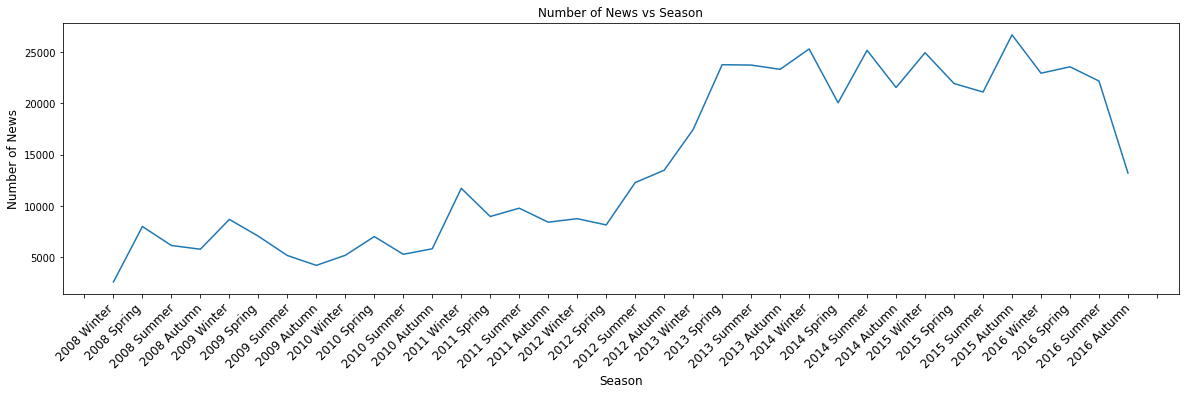

In [281]:
g=sns.lineplot(x=list(range(36)), y="title", data = news_by_season)
fig = g.get_figure()
g.figure.set_size_inches(20,5)
g.xaxis.set_major_locator(plt.MultipleLocator(1))
g.set_xticklabels(rotation=45, labels=['buffer']+year_season, fontsize='large')
g.set_xlabel('Season',fontsize='large')
g.set_ylabel('Number of News',fontsize='large')
g.set_title('Number of News vs Season',fontsize='large')
fig.savefig('News_vs_Season.png',dpi=300)

In [274]:
plt.savefig('News vs Season.png')

<Figure size 432x288 with 0 Axes>

In [25]:
#Number of Votes vs Season
votes_by_season = df[['year','season','up_votes']].groupby(['year','season']).sum()

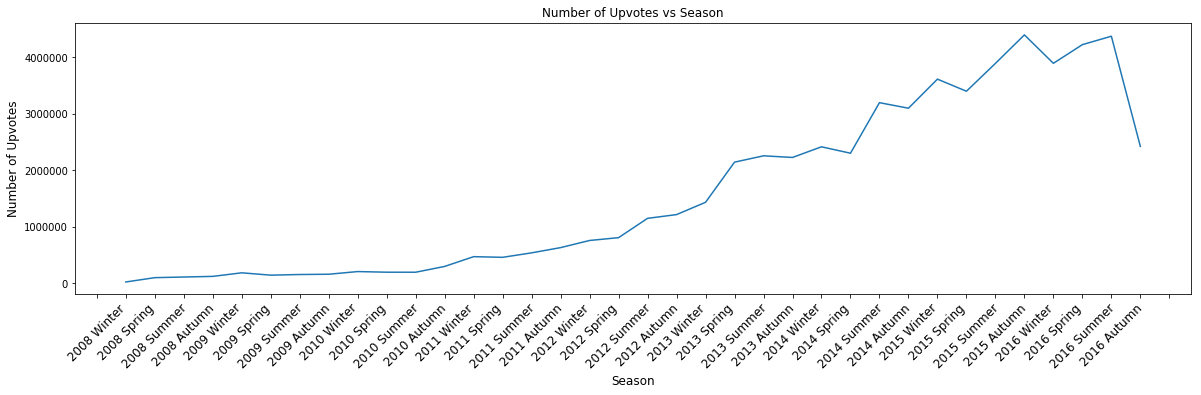

In [28]:
g=sns.lineplot(x=list(range(36)), y="up_votes", data = votes_by_season)
g.figure.set_size_inches(20,5)
g.xaxis.set_major_locator(plt.MultipleLocator(1))
g.set_xticklabels(rotation=45, labels=['buffer']+year_season, fontsize='large')
g.set_xlabel('Season',fontsize='large')
g.set_ylabel('Number of Upvotes',fontsize='large')
g.set_title('Number of Upvotes vs Season',fontsize='large')
plt.show()

## optimal pulication time

In [41]:
publ_by_time = df.groupby('time_created')['up_votes'].count()#.sort_values(ascending = False)

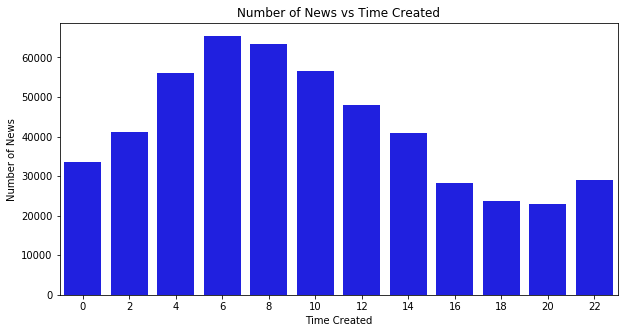

In [55]:
g=sns.barplot(x=time_list,y=list(publ_by_time),orient='v',color='b')
g.figure.set_size_inches(10,5)
g.set_xlabel("Time Created")
g.set_ylabel("Number of News")
g.set_title('Number of News vs Time Created',fontsize='large')
plt.show()

In [45]:
votes_by_time = df.groupby('time_created')['up_votes'].mean()#.sort_values(ascending = False)

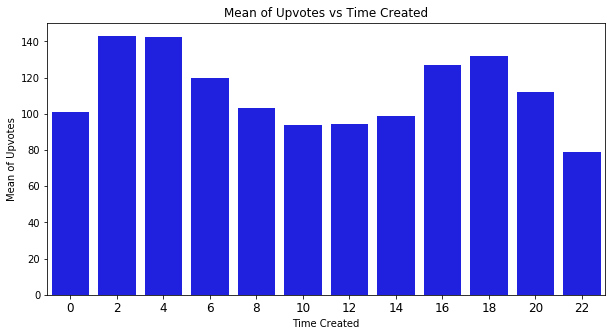

In [77]:
g=sns.barplot(x = list(range(12)), y=list(votes_by_time),orient='v',color='b')
g.figure.set_size_inches(10,5)
g.set_xlabel("Time Created")
g.set_xticklabels( labels=time_list, fontsize='large')
g.set_ylabel("Mean of Upvotes")
g.set_title('Mean of Upvotes vs Time Created',fontsize='large')
plt.show()

In [57]:
publ_by_daytime = df.groupby(['weekday_created','time_created'])['up_votes'].count()#.sort_values(ascending = False)

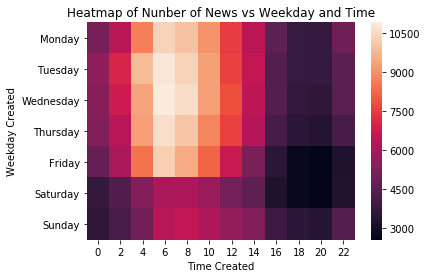

In [284]:
heatdata = np.array(publ_by_daytime).reshape([7,12])
ax = sns.heatmap(heatdata, xticklabels=time_list, yticklabels=weekday_list)
plt.xlabel("Time Created")
plt.ylabel("Weekday Created")
plt.title('Heatmap of Nunber of News vs Weekday and Time')

fig = ax.get_figure()
fig.savefig('News_vs_time.png',dpi=200)
# plt.show()

In [75]:
votes_by_daytime = df.groupby(['weekday_created','time_created'])['up_votes'].mean()#.sort_values(ascending = False)

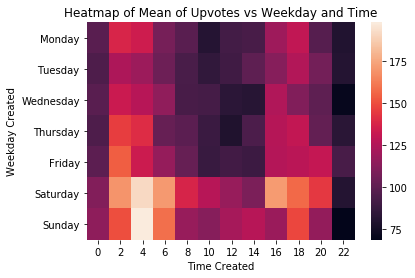

In [285]:
heatdata = np.array(votes_by_daytime).reshape([7,12])
ax = sns.heatmap(heatdata, xticklabels=time_list, yticklabels=weekday_list)
plt.xlabel("Time Created")
plt.ylabel("Weekday Created")
plt.title('Heatmap of Mean of Upvotes vs Weekday and Time')

fig = ax.get_figure()
fig.savefig('upvotes_vs_time.png',dpi=200)
# plt.show()

## build the corpus

In [79]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [80]:
# To get the stems of words in a sentence.
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# To get the words themself in a sentence.
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [81]:
#lowercase
title = df.title.str.lower()

In [82]:
# Get full stems and tokens to build vocabulary
def tokenized_stemmed(title):
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in title:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
    return totalvocab_stemmed, totalvocab_tokenized

In [86]:
totalvocab_stemmed_, totalvocab_tokenized_ = tokenized_stemmed(title)

In [158]:
print(len(totalvocab_stemmed_))

7194609


In [153]:
pickle.dump((totalvocab_stemmed_, totalvocab_tokenized_), open( "stem_token_.pkl", "wb" ))

# totalvocab_stemmed_, totalvocab_tokenized_ = pickle.load(open( "stem_token_.pkl", "rb" ))

In [89]:
# Rule out repetitions of stem-token pairs
totalvocab = zip(totalvocab_stemmed_, totalvocab_tokenized_)
totalvocab = list(set(totalvocab))
totalvocab_stemmed, totalvocab_tokenized = zip(*totalvocab)

pickle.dump((totalvocab_stemmed, totalvocab_tokenized), open( "stem_token.pkl", "wb" ))

# totalvocab_stemmed, totalvocab_tokenized = pickle.load(open( "stem_token.pkl", "rb" ))

In [159]:
print(len(totalvocab_stemmed))

114842


In [223]:
#stem-token vocabulary
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

pickle.dump(vocab_frame, open('vocab_frame.pkl','wb'))

# vocab_frame = pickle.load(open('vocab_frame.pkl','rb'))

In [95]:
# Build stopwords set. Combine two common set.
import sklearn.feature_extraction.text as text
stopwords = nltk.corpus.stopwords.words('english')
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

## use tf-idf to vectorize text

In [97]:
# tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(set(totalvocab_stemmed)), stop_words=my_stop_words, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(title)

print(tfidf_matrix.shape)

(509236, 1814)


In [98]:
pickle.dump(tfidf_matrix, open( "tfidf_matrix.pkl", "wb" ))
pickle.dump(tfidf_vectorizer, open( "tfidf_vectorizer.pkl", "wb" ))

# tfidf_matrix = pickle.load(open( "tfidf_matrix.pkl", "rb" ))
# tfidf_vectorizer = pickle.load(open( "tfidf_vectorizer.pkl", "rb" ))

In [101]:
terms = np.array(tfidf_vectorizer.get_feature_names())
print(terms[:10])

pickle.dump(terms, open( "terms.pkl", "wb" ))

# terms = pickle.load(open( "terms.pkl", "rb" ))

['1st' 'abandon' 'abba' 'abbott' 'abduct' 'abe' 'abl' 'abort' 'abroad'
 'abu']


## kmeans clustering on titles

In [109]:
#set kmeans
from sklearn.cluster import KMeans

num_clusters = 20
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [125]:
from sklearn.externals import joblib
pickle.dump(km,  open('doc_cluster_k='+str(num_clusters)+'.pkl','wb'))

# km = pickle.load(open('doc_cluster_k='+str(num_clusters)+'.pkl','rb'))
# clusters = km.labels_.tolist()

In [115]:
#add cluster to df
df['cluster'] = clusters

In [116]:
#seperate every cluster
dfi = []
titlei = []
for i in range(num_clusters):
    dfi.append(df[df.cluster == i])
    titlei.append(title[dfi[i].index])
    #print length
    print(len(titlei[i]))

8395
5434
12570
4960
273989
10673
24250
9063
11797
14115
20250
18376
6946
18658
13247
8643
6951
15606
12192
13121


In [117]:
#find the most frequent common keywords
keyword_ids = [[]] *num_clusters
keywords = [[]]*num_clusters
num_keywords = 3 #number of keywords

#some cluster are too large to search, so break them in to batch.
batch = 50000
for i in range(num_clusters):
    indexi = dfi[i].index
    #break the cluster
    if len(indexi) > batch:
        batch_num = len(indexi)//50000+1
        feature_sum = 0
        for j in range(batch_num):
            index_j = indexi[batch*j: batch*(j+1)]
            feature_sum += np.sum(tfidf_matrix[index_j,:].toarray(), axis = 0)
        feature_mean = feature_sum / len(indexi)
    else:        
        feature = tfidf_matrix[dfi[i].index,:].toarray()
        feature_mean = np.array(np.mean(feature, axis = 0 ))
    keyword_id = np.argsort(feature_mean)[-1:-num_keywords-1:-1]
    keyword_ids[i] = keyword_id
    keywords[i] = terms[keyword_id]

In [120]:
pickle.dump(keywords, open( 'keywords_'+str(num_clusters)+'.pkl', "wb" ))

# keywords = pickle.load(open( 'keywords_'+str(num_clusters)+'.pkl', "rb" ))
keywords

[array(['death', 'death toll', 'toll'], dtype='<U22'),
 array(['islam', 'islam state', 'state'], dtype='<U22'),
 array(['iran', 'nuclear', 'deal'], dtype='<U22'),
 array(['saudi', 'arabia', 'saudi arabia'], dtype='<U22'),
 array(['russia', 'uk', 'polic'], dtype='<U22'),
 array(['russian', 'ukrain', 'putin'], dtype='<U22'),
 array(['new', 'world', 'new zealand'], dtype='<U22'),
 array(['india', 'pakistan', 'china'], dtype='<U22'),
 array(['ukrain', 'news', 'bbc'], dtype='<U22'),
 array(['syria', 'russia', 'assad'], dtype='<U22'),
 array(['say', 'offici', 'offici say'], dtype='<U22'),
 array(['kill', 'peopl', 'bomb'], dtype='<U22'),
 array(['minist', 'prime', 'prime minist'], dtype='<U22'),
 array(['china', 'china sea', 'sea'], dtype='<U22'),
 array(['protest', 'polic', 'thousand'], dtype='<U22'),
 array(['korea', 'north korea', 'north'], dtype='<U22'),
 array(['canadian', 'like', 'philippin'], dtype='<U22'),
 array(['attack', 'kill', 'pari'], dtype='<U22'),
 array(['israel', 'palestinia

In [122]:
#set a metric to evaluate the result of clustering
#see if the titles in the cluster match the keywords
# relevance = np.zeros(num_clusters)
# for i in range(num_clusters):
    
    relevance_count = 0
    for j in titlei[i]:
        #if the stems of the title contain any of the keywords, then they are relevant
        if set(tokenize_and_stem(j)) & set(keywords[i]): relevance_count+=1
    relevance[i] = relevance_count/dfi[i].index.shape[0]
print(relevance)

pickle.dump(relevance, open( 'relevance'+str(num_clusters)+'.pkl', "wb" ))

# relevance = pickle.load(open( 'relevance'+str(num_clusters)+'.pkl', "rb" ))

[1.         1.         1.         1.         0.08457274 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [127]:
from sklearn.decomposition import IncrementalPCA
import sys

#the size of matrix is too large
#so use IncrementalPCA and divide the matrix into chunks
chunksize_ = 30000
dimensions = 2
data = tfidf_matrix.toarray()
n = data.shape[0]
chunknum = n // chunksize_ + 1
sklearn_pca = IncrementalPCA(n_components=dimensions)
for i in range(chunknum):
    if i<chunknum-1:
        chunk = data[i*chunksize_: (i+1)*chunksize_,:]
    else:
        chunk = data[i*chunksize_: ,:]
    sklearn_pca.partial_fit(chunk)

# Computed mean per feature
mean = sklearn_pca.mean_
# # and stddev
stddev = np.sqrt(sklearn_pca.var_)

In [128]:
Xtransformed = np.empty((0,2), np.float64)
for i in range(chunknum):
    chunk = data[i*chunksize_: (i+1)*chunksize_,:]
    Xchunk = sklearn_pca.transform(chunk)
    Xtransformed = np.vstack((Xtransformed, Xchunk))
    
pickle.dump(Xtransformed, open( "Xtransformed.pkl", "wb" ))

# Xtransformed = pickle.load(open( "Xtransformed.pkl", "rb" ))

In [129]:
xs = Xtransformed[:,0]
ys = Xtransformed[:,1]

In [130]:
#set up cluster names using a dict
pair = zip(list(range(num_clusters)),[', '.join( keywords[i]) for i in range(num_clusters)])
cluster_names = dict(pair)
cluster_names

{0: 'death, death toll, toll',
 1: 'islam, islam state, state',
 2: 'iran, nuclear, deal',
 3: 'saudi, arabia, saudi arabia',
 4: 'russia, uk, polic',
 5: 'russian, ukrain, putin',
 6: 'new, world, new zealand',
 7: 'india, pakistan, china',
 8: 'ukrain, news, bbc',
 9: 'syria, russia, assad',
 10: 'say, offici, offici say',
 11: 'kill, peopl, bomb',
 12: 'minist, prime, prime minist',
 13: 'china, china sea, sea',
 14: 'protest, polic, thousand',
 15: 'korea, north korea, north',
 16: 'canadian, like, philippin',
 17: 'attack, kill, pari',
 18: 'israel, palestinian, gaza',
 19: 'year, year old, old'}

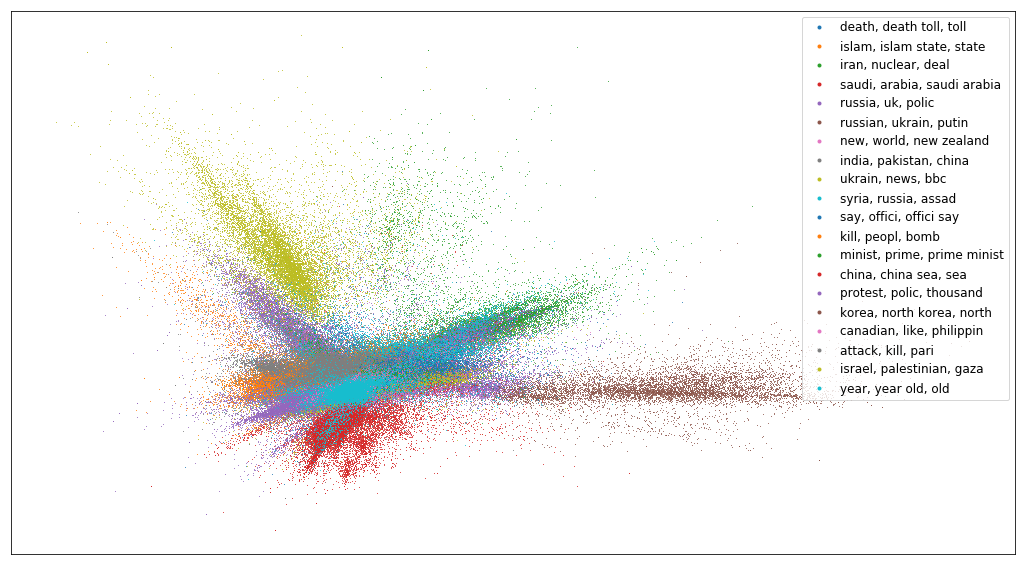

In [288]:
#create data frame that has the result of the PCA plus the cluster numbers 
dff = pd.DataFrame(dict(x=xs, y=ys, label=clusters) )

#group by cluster
groups = dff.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(18, 10)) 

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=1, 
            label=cluster_names[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1, fontsize = 12, markerscale = 4)  
fig = ax.get_figure()
fig.savefig('clusters_'+str(num_clusters)+'.png', dpi=200)
    
# plt.show()

# plt.savefig('clusters_'+str(num_clusters)+'.png', dpi=200)

## prediction for cluster

Say we want to know the trend of attacks.It belongs to Cluster 17.

In [142]:
i = 17
clu = df[df.cluster == i]

In [145]:
clu_season = clu[['year','season','title']].groupby(['year','season']).count() #count the news in the cluster vs season

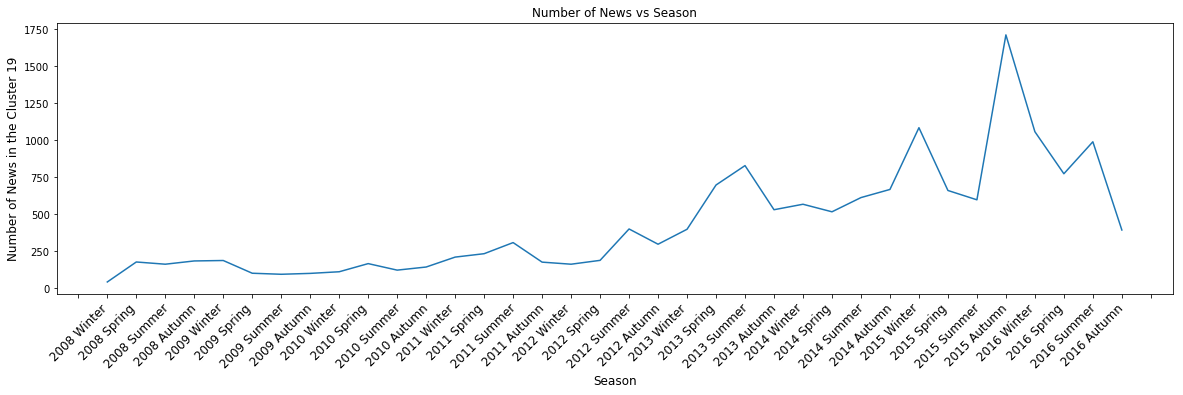

In [146]:
g=sns.lineplot(x=list(range(36)), y="title", data = clu_season)
g.figure.set_size_inches(20,5)
g.xaxis.set_major_locator(plt.MultipleLocator(1))
g.set_xticklabels(rotation=45, labels=['buffer']+year_season, fontsize='large')
g.set_xlabel('Season',fontsize='large')
g.set_ylabel('Number of News in the Cluster '+str(i),fontsize='large')
g.set_title('Number of News vs Season',fontsize='large')
plt.show()

## important and hot news

In [150]:
#important news is what the media report most
media = np.array(np.mean(tfidf_matrix, axis = 0).argsort())[0]
media_keywords = terms[media[::-1]]

In [228]:
media_keywords[:10]

array(['say', 'kill', 'china', 'attack', 'new', 'syria', 'russia',
       'world', 'iran', 'protest'], dtype='<U22')

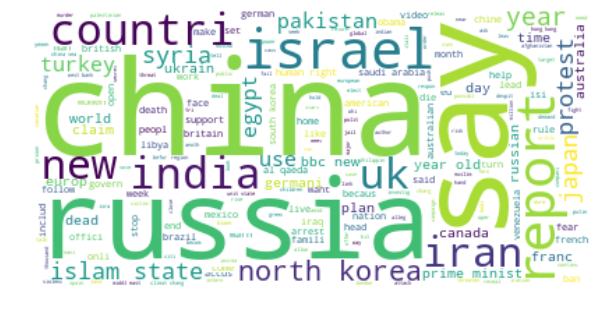

In [187]:
wordcloud = WordCloud(stopwords=my_stop_words, background_color="white").generate(', '.join(totalvocab_stemmed_))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [169]:
#hot news gets the most upvotes
#sum(votes * feature) / (number of feature existing)
#average votes
weighted_feature = np.array(df.up_votes) * tfidf_matrix /tfidf_matrix.sum(axis = 0)

In [170]:
people = np.array(weighted_feature)[0].argsort()
people_keywords = terms[people[::-1]]

In [171]:
k = people_keywords[:10]


array(['marijuana', 'edward snowden', 'edward', 'nsa', 'snowden', 'trump',
       'eleph', 'planet', 'nasa', 'religion'], dtype='<U22')

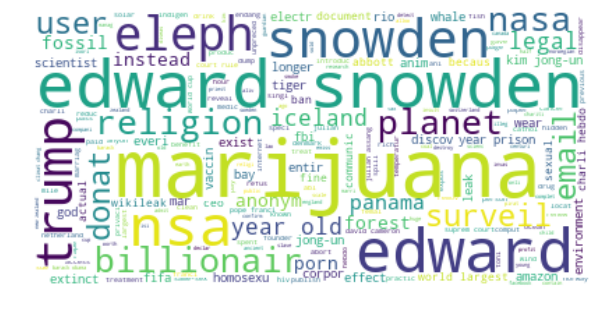

In [188]:
wc = dict(zip(terms,np.array(weighted_feature)[0]))
wordcloud = WordCloud(stopwords=my_stop_words, background_color="white").generate_from_frequencies(wc)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## most popular author

In [190]:
# the author with most votes averagely
author_votes = df[['up_votes','author']].groupby('author')
author_votes_mean = author_votes.mean()
author_votes_mean['counts'] = author_votes.count()
#at least wrote 10 articles so that can be considered
author_votes_rank = author_votes_mean[author_votes_mean.counts>=10].sort_values('up_votes', ascending = False)
popular_author = author_votes_rank.index.values[:10]


In [291]:
author_votes_rank[:5]

,up_votes,counts
author,,
neosporin,4115.181818,11
Short_Term_Account,2719.360000,50
tiribazus,2593.000000,10
mister_geaux,1857.666667,12
WorldNewsMods,1855.000000,14


In [193]:
#analize the keywords of the author
author = author_votes_rank.index[0]
author_work = df[df.author == author]
terms[np.array(tfidf_matrix[author_work.index,:].mean(axis = 0))[0].argsort()[::-1]][:10]

array(['canada', 'treati', 'gunman', 'cite', 'everi', 'democraci', 'cut',
       'canadian', 'status', 'resum'], dtype='<U22')

In [194]:
#take the 1st as an example
author_work

,time_created,date_created,up_votes,title,author,weekday_created,season,year,cluster
280441,14,2014-06-05,5775,"Quebec passes dying with dignity bill, allow...",neosporin,3,1,2014,4
281381,16,2014-06-10,4503,Canadian Cyberbullying law would let governm...,neosporin,1,1,2014,16
317132,22,2014-10-24,1752,Canada Parliament Shooting: Sgt-at-Arms Kevin ...,neosporin,4,3,2014,4
323350,10,2014-11-21,4564,"Ukraine to cancel its non-aligned status, resu...",neosporin,4,3,2014,8
327736,10,2014-12-10,2118,New documents reveal Canadian Govt. opted out ...,neosporin,2,3,2014,16
339667,12,2015-01-28,1893,Documents reveal Canada s electronic spy agenc...,neosporin,2,0,2015,4
382153,10,2015-07-11,2325,U.S. may cut Canada out of TPP,neosporin,5,2,2015,4
406706,16,2015-10-21,6813,Canada s move to legalize marijuana would be t...,neosporin,2,3,2015,4
410941,8,2015-11-06,6009,"Obama rejects Keystone XL project, citing clim...",neosporin,4,3,2015,4
435186,8,2016-02-01,7421,Canada moving ahead with plans to ditch first-...,neosporin,0,0,2016,10


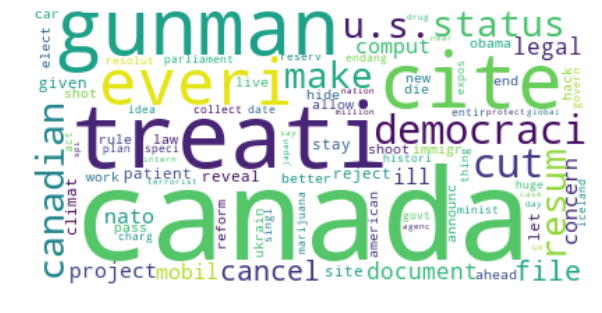

In [207]:
wc = dict(zip(terms,np.array(tfidf_matrix[author_work.index,:].mean(axis = 0))[0]))
wordcloud = WordCloud(stopwords=my_stop_words, background_color="white").generate_from_frequencies(wc)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [249]:
vocab_frame.loc['treati']

,words
treati,treaty
treati,treaties


## Recent Keywords

In [239]:
#trace back 7 days
# time_now = datetime.now()
day_range = 7
time_now = pd.Timestamp(df.iloc[-1].date_created)
recent = df.iloc[df.date_created[df.date_created.apply(pd.Timestamp) > time_now - datetime.timedelta(days = day_range)].index]

In [241]:
#feature matrix that in the time range
recent_feature = tfidf_matrix[recent.index,:]

### important events

In [242]:
#most news by media
#if a feature is reported way more frequently than before than it might be important now
times = np.array(recent_feature.sum(axis = 0) / (tfidf_matrix.mean(axis = 0) * day_range))[0]

In [243]:
#minimun reported proportion of 0.02 to avoid the case that it is not very frequent but it's too rare in the past
mintimes = recent_feature.shape[0]/50
filtered_times = times * ((recent_feature>0).toarray().sum(axis = 0)>mintimes)

In [244]:
#number of candidates
(filtered_times>0).sum()

44

In [245]:
times_rank = filtered_times.argsort()

In [246]:
impo_events = terms[times_rank[-1::-1]][:(filtered_times>0).sum()][:10]

In [247]:
print(impo_events)

['trump' 'aleppo' 'mosul' 'brexit' 'bbc news' 'indian' 'pm' 'bbc' 'turkey'
 'obama']


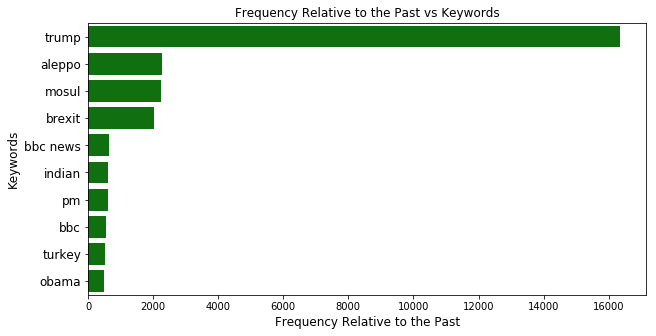

In [255]:
g=sns.barplot(y=list(range(10)),x=sorted(filtered_times,reverse = True)[:10],orient='h',color='g')
g.figure.set_size_inches(10,5)
g.set_xlabel("Frequency Relative to the Past",fontsize='large')
g.set_ylabel("Keywords",fontsize='large')
g.set_yticklabels(labels=impo_events, fontsize='large')
g.set_title('Frequency Relative to the Past vs Keywords',fontsize='large')
plt.show()

### hot news

In [256]:
#high votes bar
filtered_votes = recent[recent.up_votes > 1000]

In [258]:
#votes weight features
weighted_recent_feature = np.array(filtered_votes.up_votes) * tfidf_matrix [filtered_votes.index,:]

In [259]:
hot_rank = weighted_recent_feature.argsort()
hot_news = terms[hot_rank[::-1]]

In [260]:
print(hot_news[:10])

['trump' 'block' 'climat' 'extrem' 'surveil' 'climat chang' 'chang' 'new'
 'constitut' 'confirm']


In [262]:
#want to see what news the word 'block' is from
confused_word = 'block'

In [263]:
every_vote = (np.array(filtered_votes.up_votes).reshape([filtered_votes.shape[0],1]) * tfidf_matrix [filtered_votes.index,:].toarray())[:,tfidf_vectorizer.vocabulary_[confused_word ]]

In [264]:
filtered_votes.iloc[every_vote.argmax()].title

'UK Government Confirm Move to Force ISPs into Blocking “Adult” Sites'

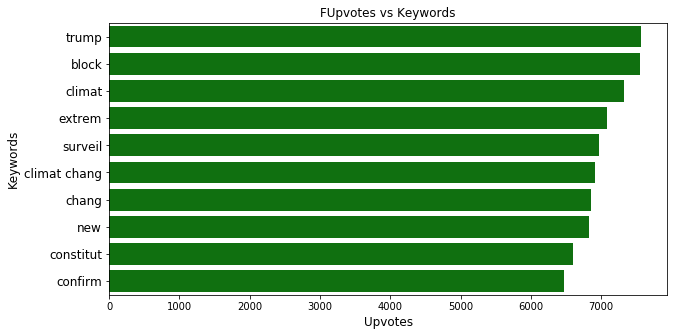

In [269]:
g=sns.barplot(y=list(range(10)),x=sorted(filtered_votes.up_votes,reverse = True)[:10],orient='h',color='g')
g.figure.set_size_inches(10,5)
g.set_xlabel("Upvotes",fontsize='large')
g.set_ylabel("Keywords",fontsize='large')
g.set_yticklabels(labels=hot_news[:10], fontsize='large')
g.set_title('FUpvotes vs Keywords',fontsize='large')
plt.show()